# Team Assignment 3: Investing in Peer2Peer Lending

By: Carter Pace, Austin Cobb, Sarah Parker, Spencer Siegel, Cecilia Zeng, Varun Srivastava

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns

# Introduction

For this assignment, our team was tasked with assisting Dr. D in his investment strategies, specifically in peer2peer lending. Dr. D came to our team with the idea of putting his funds into the LendingClub platform and decided to invest $10,000,000. Our goal for this assignment is to build a prediction model around the historical data given by LendingClub to predict based on available variables which loans are likely to be fully paid or deafulted. 

With data consisting of over 151 variables and 30 million records, developing an investment strategy that can be backed by data posed quite the task. Our team recognized that having this many variables can actually be a curse because many of them deceivingly do not have any weight on the decision of whether or not a loan will default.

Our first step as a team is to clean up this data, first looking at missing data, outliers, and other irregular patterns, before moving toward feature importance and eliminating factors that do not affect the decision process. 

# Gathering Data

The first step before creating a manageable set of variables to run a prediction model on is first gathering the data set and understanding waht LendingClub provided. 

First, we read in the data and try to understand the data set's makeup and shape

In [3]:
df_accepted = pd.read_csv("accepted_2007_to_2018Q4.csv")

/Users/spencersiegel/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (0,19,49,59,118,129,130,131,134,135,136,139,145,146,147) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
print(df_accepted.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2260701 entries, 0 to 2260700
Columns: 151 entries, id to settlement_term
dtypes: float64(113), object(38)
memory usage: 2.5+ GB
None


In [5]:
df_accepted.shape

(2260701, 151)

The task for this project is to assist Dr. D in developing a smart investment strategy by using historical data to to build a model that predicts the outcome of loans (fully paid, default, etc.). With this question in mind, our response variable is the loan status of the loans in our historical data. 

In [6]:
df_accepted.loan_status.value_counts()

Fully Paid                                             1076751
Current                                                 878317
Charged Off                                             268559
Late (31-120 days)                                       21467
In Grace Period                                           8436
Late (16-30 days)                                         4349
Does not meet the credit policy. Status:Fully Paid        1988
Does not meet the credit policy. Status:Charged Off        761
Default                                                     40
Name: loan_status, dtype: int64

Based on the above output, the primary values for the loan status are *Fully Paid*, *Current*, *Charged Off*, *Late (31-120 days)*, *In Grace Period*, *Late (16-30 days)*, and *Default*. The *Current* status of loans is not helpful for our task because we do not know the outcome of the loan (whether it is fully paid or defaulted).

So, we only included loans that were *Fully Paid*, *Charged Off*, and *Default*. 

In [7]:
df = df_accepted[df_accepted['loan_status'].isin(['Fully Paid', 'Charged Off', 'Default'])]

# Cleaning Data

The next step is narrowing down the variables from cleaning the data, before then moving into focusing on feature importance of variables. 

The first change we made to the data was to only include data entries from the years 2014-2018. When analyzing the data, we disovered that the majority of the entries are between the years 2014 & 2018. We decided to remove all data before the year 2014 for simplification. The main reason we wanted to remove entries from the prior years is becaus from 2007 to 2018, there were many fluctuations in the interest rate that would affect whether a loan would be fully paid or defaulted. Specifically, from 2007-2009, during the rise and fall of the great recession, the interest rate on loans and the ability for people to pay them off changed drastically. To simplify this, we decided to constrict the years, but still aiming to capture the majority of the data. 

In [8]:
df['year'] = df['issue_d'].str.strip().str[-4:]

/Users/spencersiegel/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [9]:
df.year.value_counts()

2015    375546
2016    293105
2014    223103
2017    169321
2013    134804
2018     56318
2012     53367
2011     21721
2010     11536
2009      4716
2008      1562
2007       251
Name: year, dtype: int64

In [10]:
df = df[df['year'].isin(['2014', '2015', '2016', '2017', '2018'])]

In [11]:
df.shape

(1117393, 152)

In [12]:
df.columns

Index(['id', 'member_id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv',
       'term', 'int_rate', 'installment', 'grade', 'sub_grade',
       ...
       'hardship_last_payment_amount', 'disbursement_method',
       'debt_settlement_flag', 'debt_settlement_flag_date',
       'settlement_status', 'settlement_date', 'settlement_amount',
       'settlement_percentage', 'settlement_term', 'year'],
      dtype='object', length=152)

In [13]:
total_num = df.isnull().sum().sort_values(ascending=False)

The next step is to handle any missing data in the data set. First, we looked at the total number of missing values for each column and what percentage the missing values make up of the total values for that column.

In [14]:
perc = df.isnull().sum()/df.isnull().count() *100
perc1 = (round(perc,2).sort_values(ascending=False))

# Creating a data frame:
df_miss = pd.concat([total_num, perc1], axis =1 , keys =["Total Missing Values", "Percentage %"]).sort_values(by ="Percentage %", ascending = False)

/Users/spencersiegel/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """


As a team, we decided to only include columns that have missing values comprising of less than 10% of the total number of values. Any variables that have more than 10% of their values missing should not be imputed because there is not enough information to accurately impute the missing values. 

In [15]:
top_mis = df_miss[df_miss["Percentage %"]<10]
top_mis.reset_index(inplace=True)
vals = list(top_mis['index'])

With the below output, we have now removed any columns with more than 10% missing data. Our team checked the shape of the data and have now narrowed the columns down from 151 to 94. 

In [16]:
df = df[vals]

In [17]:
df.shape

(1117393, 94)

Before handling the rest of the missing values, our team analyzed the correlations between variables. Variables that are highly correlated or highly inversely correlated have a strong relationship and can give the same information and can skew the results. Specifically, we are only looking at correlation between numerical variables. Correlation between categorical variables does not give any useful information. 

In [18]:
num_feat = df.select_dtypes('number').columns.values
df[num_feat].nunique().sort_values()

policy_code               1
num_tl_30dpd              5
num_tl_120dpd_2m          6
inq_last_6mths            7
acc_now_delinq            8
                     ...   
tot_hi_cred_lim      405183
total_rec_int        464335
last_pymnt_amnt      615096
total_pymnt_inv      878429
total_pymnt         1047106
Length: 69, dtype: int64

In [19]:
from itertools import combinations
from scipy.stats import pearsonr

df2 = df.dropna()
num_feat = df2.select_dtypes('number').columns.values
comb_num_feat = np.array(list(combinations(num_feat, 2)))
corr_num_feat = np.array([])
for comb in comb_num_feat:
    corr = pearsonr(df2[comb[0]], df2[comb[1]])[0]
    corr_num_feat = np.append(corr_num_feat, corr)

/Users/spencersiegel/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3399: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


In [20]:
corr_num_feat

array([ 0.00099082, -0.01138136,  0.09027688, ...,  0.51358516,
        0.04309921,  0.25589371])

The above output gives the correlation between each pair of variables. Our team decided that any correlation about 0.8 in absolute value is too high and one of the variables within that correlation should be dropped. The variable dropped in the highly correlated pair was arbitrary because high correlation gives the same information in both variables. 

In [21]:
high_corr_num = comb_num_feat[np.abs(corr_num_feat) >= 0.8]
high_corr_num

/Users/spencersiegel/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in greater_equal
  """Entry point for launching an IPython kernel.


array([['bc_util', 'percent_bc_gt_75'],
       ['bc_util', 'revol_util'],
       ['bc_open_to_buy', 'total_bc_limit'],
       ['revol_bal', 'total_rev_hi_lim'],
       ['recoveries', 'collection_recovery_fee'],
       ['total_pymnt_inv', 'total_rec_prncp'],
       ['total_pymnt_inv', 'total_pymnt'],
       ['total_pymnt_inv', 'installment'],
       ['total_pymnt_inv', 'funded_amnt_inv'],
       ['total_pymnt_inv', 'funded_amnt'],
       ['total_pymnt_inv', 'loan_amnt'],
       ['total_rec_prncp', 'total_pymnt'],
       ['total_pymnt', 'installment'],
       ['total_pymnt', 'funded_amnt_inv'],
       ['total_pymnt', 'funded_amnt'],
       ['total_pymnt', 'loan_amnt'],
       ['total_il_high_credit_limit', 'total_bal_ex_mort'],
       ['tot_hi_cred_lim', 'tot_cur_bal'],
       ['tot_cur_bal', 'avg_cur_bal'],
       ['num_actv_bc_tl', 'num_bc_sats'],
       ['num_actv_bc_tl', 'num_rev_tl_bal_gt_0'],
       ['num_actv_bc_tl', 'num_actv_rev_tl'],
       ['out_prncp_inv', 'out_prncp'],
     

In [22]:
df3 = df.drop(np.unique(high_corr_num[:, 0]), axis=1, errors='ignore')
df3.shape

(1117393, 73)

In [23]:
df3.head()

,mths_since_recent_inq,emp_title,emp_length,num_tl_120dpd_2m,mo_sin_old_il_acct,title,percent_bc_gt_75,mths_since_recent_bc,last_pymnt_d,revol_util,...,num_accts_ever_120_pd,mort_acc,mo_sin_rcnt_tl,mo_sin_rcnt_rev_tl_op,mo_sin_old_rev_tl_op,loan_status,loan_amnt,last_pymnt_amnt,last_fico_range_low,zip_code
0,4.0,leadman,10+ years,0.0,148.0,Debt consolidation,0.0,4.0,Jan-2019,29.7,...,2.0,1.0,3.0,3.0,128.0,Fully Paid,3600.0,122.67,560.0,190xx
1,0.0,Engineer,10+ years,0.0,113.0,Business,7.7,2.0,Jun-2016,19.2,...,0.0,4.0,2.0,2.0,192.0,Fully Paid,24700.0,926.35,695.0,577xx
2,10.0,truck driver,10+ years,0.0,125.0,NaN,50.0,101.0,Jun-2017,56.2,...,0.0,5.0,14.0,14.0,184.0,Fully Paid,20000.0,15813.30,700.0,605xx
4,1.0,Contract Specialist,3 years,0.0,128.0,Major purchase,60.0,4.0,Jul-2016,64.5,...,0.0,6.0,4.0,4.0,210.0,Fully Paid,10400.0,10128.96,700.0,174xx
5,NaN,Veterinary Tecnician,4 years,0.0,338.0,Debt consolidation,100.0,36.0,May-2017,68.4,...,0.0,0.0,32.0,32.0,54.0,Fully Paid,11950.0,7653.56,755.0,300xx


In [24]:
df3['loan_status'].value_counts()

Fully Paid     884132
Charged Off    233221
Default            40
Name: loan_status, dtype: int64

Now that we have narrowed down the numerical variables from the correlation, our team then decided to break out the variables identified as 'object'to narrow down the list of variables and determine which can be removed before creating the prediction model.

In [25]:
df4 = df3.select_dtypes(include='object')

In [26]:
df4.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1117393 entries, 0 to 2260697
Data columns (total 25 columns):
emp_title               1045806 non-null object
emp_length              1047842 non-null object
title                   1100752 non-null object
last_pymnt_d            1115301 non-null object
pymnt_plan              1117393 non-null object
purpose                 1117393 non-null object
sub_grade               1117393 non-null object
year                    1117393 non-null object
verification_status     1117393 non-null object
url                     1117393 non-null object
term                    1117393 non-null object
initial_list_status     1117393 non-null object
id                      1117393 non-null object
home_ownership          1117393 non-null object
hardship_flag           1117393 non-null object
grade                   1117393 non-null object
earliest_cr_line        1117393 non-null object
disbursement_method     1117393 non-null object
debt_settlement_flag   

After looking at the list of variables labeled as 'object', there were many that does any give any information to indicate the status of the loan (fully paid, defaulted). Some of these include the id, the url of the loan, and the self-made title of the loan. Additionally, we removed variables that are reduntant with other variables that are already included. Lastly, we removed to numerical variables that were missed in the correlation count. 

In [27]:
drop_col = ['emp_title', 
            'title', 
            'last_pymnt_d', 
            'pymnt_plan', 
            'url', 
            'id', 
            'hardship_flag', 
            'grade', 
            'earliest_cr_line', 
            'year', 
            'last_credit_pull_d', 
            'zip_code',
            
            ##numerical variables
            'last_fico_range_low',
            'last_pymnt_amnt',
            ]

In [28]:
df3 = df3.drop(drop_col, axis=1)

After dropping these variables, we are left with only 59 out of 151, getting closer to a much more manageable number of variables to run a model on. 

In [29]:
df3.shape

(1117393, 59)

In [30]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1117393 entries, 0 to 2260697
Data columns (total 59 columns):
mths_since_recent_inq         1010973 non-null float64
emp_length                    1047842 non-null object
num_tl_120dpd_2m              1067773 non-null float64
mo_sin_old_il_acct            1085475 non-null float64
percent_bc_gt_75              1104650 non-null float64
mths_since_recent_bc          1105784 non-null float64
revol_util                    1116711 non-null float64
dti                           1117019 non-null float64
policy_code                   1117393 non-null float64
pub_rec                       1117393 non-null float64
pub_rec_bankruptcies          1117393 non-null float64
purpose                       1117393 non-null object
acc_now_delinq                1117393 non-null float64
sub_grade                     1117393 non-null object
tax_liens                     1117393 non-null float64
verification_status           1117393 non-null object
total_rev_h

With the remaining 'object' labeled variables, the team cast them to categorical variables to continue the analysis. Futher along in this notebook, we will create dummy variables out of the categorical variables to run the model. 

In [31]:
df4 = df3.select_dtypes(include='object')
categorical_features = list(df4.columns)

In [32]:
for col in categorical_features:
    df3[col] = df3[col].astype('category')

In [33]:
df3['policy_code'] = df3['policy_code'].astype('category')

In [34]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1117393 entries, 0 to 2260697
Data columns (total 59 columns):
mths_since_recent_inq         1010973 non-null float64
emp_length                    1047842 non-null category
num_tl_120dpd_2m              1067773 non-null float64
mo_sin_old_il_acct            1085475 non-null float64
percent_bc_gt_75              1104650 non-null float64
mths_since_recent_bc          1105784 non-null float64
revol_util                    1116711 non-null float64
dti                           1117019 non-null float64
policy_code                   1117393 non-null category
pub_rec                       1117393 non-null float64
pub_rec_bankruptcies          1117393 non-null float64
purpose                       1117393 non-null category
acc_now_delinq                1117393 non-null float64
sub_grade                     1117393 non-null category
tax_liens                     1117393 non-null float64
verification_status           1117393 non-null category
to

# Finetuning the Model

The next section of the notebook walks through our team's process of removing variables based on feature importance to continue finetuning the model down to something that can adequately predict what the status of a loan will be. Before that, we decided to include a new variable, *libor*, which is the London average interest rate of banks. The purpose of this new variable is to standardize the interest rates across years to take out any variability that occurs from external factors during that time. 

In [35]:
libor = pd.read_csv('libor.csv') #where to find??
libor.head()

,month,libor
0,Jan-2020,1.66
1,Dec-2019,1.76
2,Nov-2019,1.69
3,Oct-2019,1.79
4,Sep-2019,2.02


In [36]:
df3['issue_d'] = df3['issue_d'].astype('object')
df123 = pd.merge(df3, libor, left_on='issue_d', right_on='month')
df123.head()

,mths_since_recent_inq,emp_length,num_tl_120dpd_2m,mo_sin_old_il_acct,percent_bc_gt_75,mths_since_recent_bc,revol_util,dti,policy_code,pub_rec,...,acc_open_past_24mths,num_accts_ever_120_pd,mort_acc,mo_sin_rcnt_tl,mo_sin_rcnt_rev_tl_op,mo_sin_old_rev_tl_op,loan_status,loan_amnt,month,libor
0,4.0,10+ years,0.0,148.0,0.0,4.0,29.7,5.91,1.0,0.0,...,4.0,2.0,1.0,3.0,3.0,128.0,Fully Paid,3600.0,Dec-2015,0.42
1,0.0,10+ years,0.0,113.0,7.7,2.0,19.2,16.06,1.0,0.0,...,4.0,0.0,4.0,2.0,2.0,192.0,Fully Paid,24700.0,Dec-2015,0.42
2,10.0,10+ years,0.0,125.0,50.0,101.0,56.2,10.78,1.0,0.0,...,6.0,0.0,5.0,14.0,14.0,184.0,Fully Paid,20000.0,Dec-2015,0.42
3,1.0,3 years,0.0,128.0,60.0,4.0,64.5,25.37,1.0,0.0,...,10.0,0.0,6.0,4.0,4.0,210.0,Fully Paid,10400.0,Dec-2015,0.42
4,NaN,4 years,0.0,338.0,100.0,36.0,68.4,10.20,1.0,0.0,...,0.0,0.0,0.0,32.0,32.0,54.0,Fully Paid,11950.0,Dec-2015,0.42


In [37]:
df123 = df123.drop('month', axis=1)
df123.shape

(1117393, 60)

After including libor into the model, it is time to begin testing. For this model, we are utilizing the Pipeline method. First, we separate the features into numeric and categorical to develop the two pipelines with the imputing method for each type of variable. There two pipelines create the preprocessor (Main Pipeline). 

In [38]:
numeric_features = df123.select_dtypes(include=['int64', 'float64']).columns
categorical_features = df123.select_dtypes(include=['object', 'category']).columns
categorical_features=categorical_features.drop(['loan_status'])

In [39]:
df123['loan_status']=np.where(df123.loan_status=='Default','Charged Off',df123.loan_status)

In [40]:
df123 = df123.drop(['issue_d','addr_state'], axis=1)
data=df123.copy().sample(n=50000, random_state=1)
numeric_features = data.select_dtypes(include=['int64', 'float64']).columns
categorical_features = data.select_dtypes(include=['object', 'category']).columns
categorical_features=categorical_features.drop(['loan_status'])
X = data.loc[:, data.columns != 'loan_status']
# Create a new dataframe y that includes only our 
y = data.loan_status

In [41]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

#1 Inner Pipeline1: Create a numeric transformer with 2 steps
numeric_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy = 'median'))])

#2 Inner Pipeline2: Create a categorical transformer with 2 steps
categorical_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent')), ('onehot', OneHotEncoder(drop='first'))])

#3 Create preprocessor
preprocessor = ColumnTransformer(
    transformers = [
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

With our Pipeline, our team decided to feed in the **Random Forest Classifier** for classification of the loan_status response variable as fully paid or defaulted. 

0.9284
              precision    recall  f1-score   support

 Charged Off       1.00      0.66      0.79      3104
  Fully Paid       0.92      1.00      0.96     11896

    accuracy                           0.93     15000
   macro avg       0.96      0.83      0.87     15000
weighted avg       0.93      0.93      0.92     15000



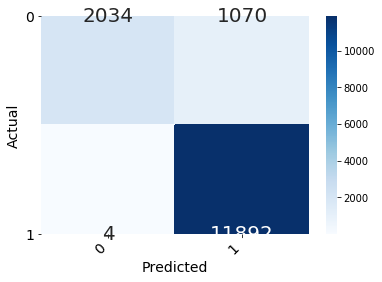

In [42]:
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.feature_selection import SelectFromModel, SelectKBest
from matplotlib import pyplot as plt
MainPipe = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', RandomForestClassifier(n_estimators=90) )])
#('fs',SelectFromModel(ExtraTreesClassifier())),
# split sample into train and test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, stratify=y,random_state=42)  # random_state=21 # stratify=y


# Fit Model
MainPipe.fit(X_train,y_train)

# Predict model
y_pred = MainPipe.predict(X_test)

# Output the accuracy of our prediction
from sklearn.metrics import accuracy_score
print(accuracy_score(y_test, y_pred))

# Visualize the confusion matrix to make it easier to read
from sklearn.metrics import confusion_matrix
con_matrix = confusion_matrix(y_test, y_pred)
confusion_matrix_df = pd.DataFrame(con_matrix, ('0', '1'), ('0', '1'))
heatmap = sns.heatmap(confusion_matrix_df, annot=True, annot_kws={"size": 20}, fmt="d", cmap="Blues")
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize = 14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize = 14)
plt.ylabel('Actual', fontsize = 14)
plt.xlabel('Predicted', fontsize = 14)

# Print the classification report
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

After this first run through, our f1 score for accuracy is 0.92, which is an incredible score. However, upon scanning the varaibles in the feature importance output below, our team noticed that many of the variables would not actually be information available to the investor at the time of investing. With that being said, we decided to remove the variables that would not be available at the time of investing, even though this will bring down the accuracy of our prediction model. 

In [43]:
mult_value=[]
for col in pd.get_dummies(X_train, drop_first=True):
    mult_value.append(len(pd.get_dummies(X_train, drop_first=True)[col].unique())!=1)

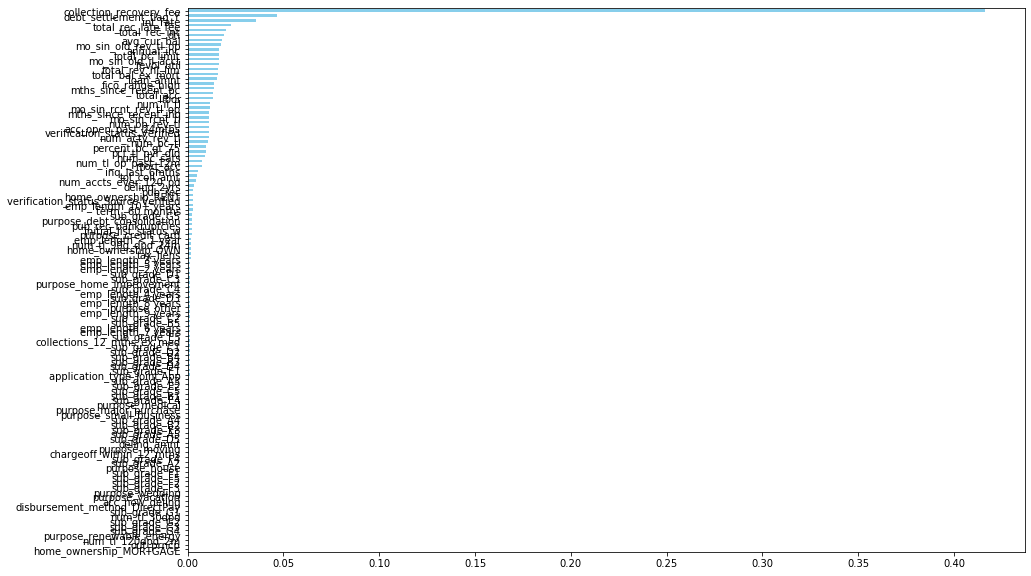

In [44]:
importances_rf = pd.Series(MainPipe.named_steps['classifier'].feature_importances_,
                          index = pd.get_dummies(X,drop_first=True).drop(['home_ownership_NONE','purpose_educational'],axis=1).columns)

#Sort importances_rf
sorted_importances_rf = importances_rf.sort_values()

#Make a horizontal bar plot
plt.figure(figsize=(15,10))
sorted_importances_rf.plot(kind='barh', color='skyblue');
plt.show()

In [45]:
sorted_importances_rf[-30:].index.tolist()

['pct_tl_nvr_dlq',
 'percent_bc_gt_75',
 'num_bc_tl',
 'num_actv_rev_tl',
 'verification_status_Verified',
 'acc_open_past_24mths',
 'num_op_rev_tl',
 'mo_sin_rcnt_tl',
 'mths_since_recent_inq',
 'mo_sin_rcnt_rev_tl_op',
 'num_il_tl',
 'libor',
 'total_acc',
 'mths_since_recent_bc',
 'fico_range_high',
 'loan_amnt',
 'total_bal_ex_mort',
 'total_rev_hi_lim',
 'revol_util',
 'mo_sin_old_il_acct',
 'total_bc_limit',
 'annual_inc',
 'mo_sin_old_rev_tl_op',
 'avg_cur_bal',
 'dti',
 'total_rec_int',
 'total_rec_late_fee',
 'int_rate',
 'debt_settlement_flag_Y',
 'collection_recovery_fee']

In [46]:
drop_vars = [
 'num_op_rev_tl',
 'acc_open_past_24mths',
 'mo_sin_rcnt_tl',
 'mths_since_recent_inq',    
 'num_il_tl',        
 'mths_since_recent_bc',
 'total_rev_hi_lim', 
 'total_bc_limit', 
 'total_bal_ex_mort',
 'mo_sin_old_il_acct',
 'mo_sin_old_rev_tl_op',
 'avg_cur_bal',
 'total_rec_int',
 'total_rec_late_fee',
 'debt_settlement_flag',
 'collection_recovery_fee'
]

In [47]:
df123 = df123.drop(drop_vars, axis=1)
data=df123.copy().sample(n=50000, random_state=1)
numeric_features = data.select_dtypes(include=['int64', 'float64']).columns
categorical_features = data.select_dtypes(include=['object', 'category']).columns
categorical_featuers=categorical_features.drop(['loan_status'])
X = data.loc[:, data.columns != 'loan_status']

y = data.loan_status

In [48]:
df123.shape

(1117393, 42)

Although we do not explicitly show these steps, our teams runs the model one more time to find a final list of variables to drop, many of which are also not available during the time of investing.

As an aside, we determined the variables that were not available at the time of investing by researching into the LendingClub.com platform to analyze which variables are available. 

In [49]:

final_drop_vars = [
 'out_prncp', #dropping because 0 feature importance
 'num_tl_120dpd_2m',
 'num_tl_30dpd',
 'chargeoff_within_12_mths',         #dont think we have this but double check
 'tax_liens',                 #don think we have this, but check
 'num_accts_ever_120_pd',
 'tot_coll_amt',               #we only have "total collections excluding medical" (listed above)
 'num_tl_op_past_12m',
 'num_bc_sats',             
 'num_actv_rev_tl',
 'num_bc_tl',
]

In [50]:
#final removal

df123 = df123.drop(final_drop_vars, axis=1)
data=df123.copy().sample(n=50000, random_state=1)
numeric_features = data.select_dtypes(include=['int64', 'float64']).columns
categorical_features = data.select_dtypes(include=['object', 'category']).columns
categorical_features=categorical_features.drop(['loan_status'])
X = data.loc[:, data.columns != 'loan_status']
# Create a new dataframe y that includes only our 
y = data.loan_status

# Sub Grade Chart

As we have finetuned the variables to be included in the model, our team turned toward the **sub grade** variable to determine its importance in the model. For context, each loan has a grade (A, B, C, etc.) and each grade has sub grades that give an ordering of loans within each grade (A1, A2, B1, etc.). 

First we created a subset dataframe only containing *loan_status* as the response variable and *sub_grade* as the dependent variable. 

In [51]:
df_sub_grade = df123[['sub_grade', 'loan_status']]
data=df_sub_grade.copy().sample(n=50000, random_state=1)
numeric_features = data.select_dtypes(include=['int64', 'float64']).columns
categorical_features = data.select_dtypes(include=['object', 'category']).columns
categorical_features=categorical_features.drop(['loan_status'])
X = data.loc[:, data.columns != 'loan_status']
# Create a new dataframe y that includes only our 
y = data.loan_status

In [52]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
#from sklearn.impute import Imputer
from sklearn.compose import ColumnTransformer


#1 Inner Pipeline1: Create a numeric transformer with 2 steps
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy = 'median'))])

#2 Inner Pipeline2: Create a categorical transformer with 2 steps
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(drop='first'))])

#3 Create Preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

0.7918
              precision    recall  f1-score   support

 Charged Off       0.45      0.03      0.05      3104
  Fully Paid       0.80      0.99      0.88     11896

    accuracy                           0.79     15000
   macro avg       0.62      0.51      0.47     15000
weighted avg       0.72      0.79      0.71     15000



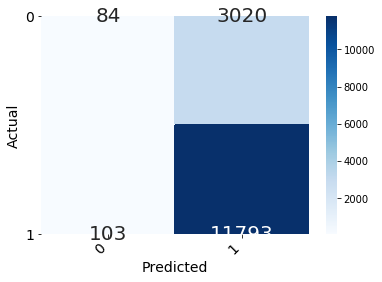

In [53]:
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.feature_selection import SelectFromModel, SelectKBest
from matplotlib import pyplot as plt
MainPipe = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', RandomForestClassifier(n_estimators=90) )])
#('fs',SelectFromModel(ExtraTreesClassifier())),
# split sample into train and test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, stratify=y,random_state=42)  # random_state=21 # stratify=y


# Fit Model
MainPipe.fit(X_train,y_train)

# Predict model
y_pred = MainPipe.predict(X_test)

# Output the accuracy of our prediction
from sklearn.metrics import accuracy_score
print(accuracy_score(y_test, y_pred))

# Visualize the confusion matrix to make it easier to read
from sklearn.metrics import confusion_matrix
con_matrix = confusion_matrix(y_test, y_pred)
confusion_matrix_df = pd.DataFrame(con_matrix, ('0', '1'), ('0', '1'))
heatmap = sns.heatmap(confusion_matrix_df, annot=True, annot_kws={"size": 20}, fmt="d", cmap="Blues")
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize = 14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize = 14)
plt.ylabel('Actual', fontsize = 14)
plt.xlabel('Predicted', fontsize = 14)

# Print the classification report
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

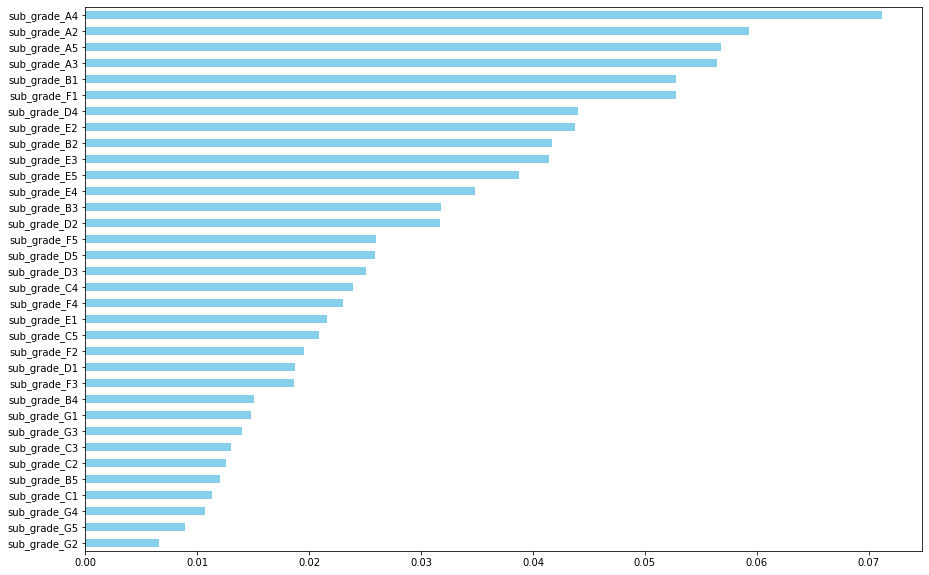

In [54]:
import pandas as pd
import matplotlib.pyplot as plt

# Create a pd.Series of features importances
importances_rf = pd.Series(MainPipe.named_steps['classifier'].feature_importances_, index = pd.get_dummies(X,drop_first=True).columns)

# Sort importances_rf
sorted_importances_rf = importances_rf.sort_values()

# Make a horizontal bar plot
plt.figure(figsize=(15,10))
sorted_importances_rf.plot(kind='barh', color='skyblue'); 
plt.show()

After running the model, we find an accuracy score of 0.792 in prediction however, the feature importance for these variables is very small, so we found this variable unnecessary. 

# Other Features

Now, our team will run the model without the *sub_grade* variable. 

In [55]:
df_other_features = df123.drop(['sub_grade'], axis=1)
data=df_other_features.copy().sample(n=50000, random_state=1)

numeric_features = data.select_dtypes(include=['int64', 'float64']).columns
categorical_features = data.select_dtypes(include=['object', 'category']).columns
categorical_features=categorical_features.drop(['loan_status'])
X = data.loc[:, data.columns != 'loan_status']
# Create a new dataframe y that includes only our 
y = data.loan_status

In [56]:
#1 Inner Pipeline1: Create a numeric transformer with 2 steps
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy = 'median'))])

#2 Inner Pipeline2: Create a categorical transformer with 2 steps
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(drop='first'))])

#3 Create Preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

0.7964666666666667
              precision    recall  f1-score   support

 Charged Off       0.56      0.08      0.14      3104
  Fully Paid       0.80      0.98      0.88     11896

    accuracy                           0.80     15000
   macro avg       0.68      0.53      0.51     15000
weighted avg       0.75      0.80      0.73     15000



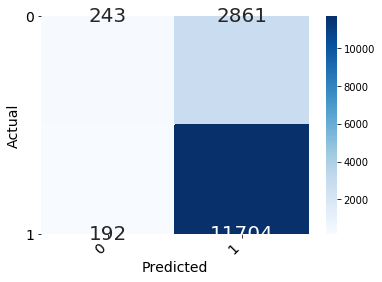

In [57]:
MainPipe = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', RandomForestClassifier(n_estimators=90) )])
# split sample into train and test

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, stratify=y,random_state=42)  # random_state=21 # stratify=y

# Fit Model
MainPipe.fit(X_train,y_train)

# Predict model
y_pred = MainPipe.predict(X_test)

#Output accuracy of our prediction
print(accuracy_score(y_test, y_pred))

# Visualize the confusion matrix to make it easier to read
con_matrix = confusion_matrix(y_test, y_pred)
confusion_matrix_df = pd.DataFrame(con_matrix, ('0', '1'), ('0', '1'))
heatmap = sns.heatmap(confusion_matrix_df, annot=True, annot_kws={"size": 20}, fmt="d", cmap="Blues")
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize = 14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize = 14)
plt.ylabel('Actual', fontsize = 14)
plt.xlabel('Predicted', fontsize = 14)

# Print the classification report
print(classification_report(y_test, y_pred))

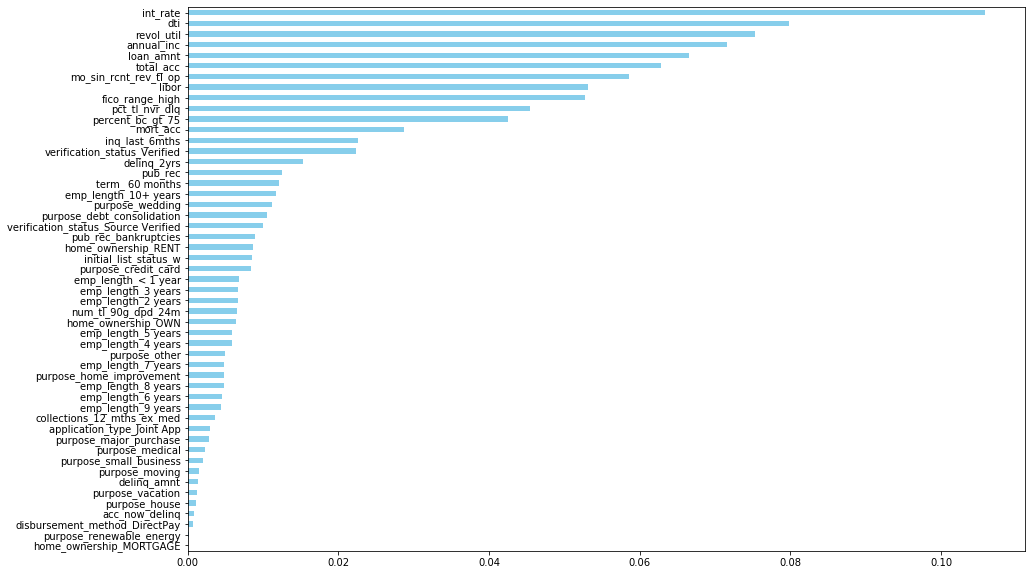

In [58]:
# Create a pd.Series of features importances
importances_rf = pd.Series(MainPipe.named_steps['classifier'].feature_importances_, index = pd.get_dummies(X,drop_first=True).drop(['home_ownership_NONE','purpose_educational'],axis=1).columns)

# Sort importances_rf
sorted_importances_rf = importances_rf.sort_values()

# Make a horizontal bar plot
plt.figure(figsize=(15,10))
sorted_importances_rf.plot(kind='barh', color='skyblue'); 
plt.show()

Still, by the looks of our feature importance graph, there are many variables that have little importance to our model. Therefore, our team made the decision to drop any varibles that have a feature importance less than 0.01.

In [59]:
drop = sorted_importances_rf[sorted_importances_rf > 0.01]
drop = drop.index.tolist()
drop

['verification_status_Source Verified',
 'purpose_debt_consolidation',
 'purpose_wedding',
 'emp_length_10+ years',
 'term_ 60 months',
 'pub_rec',
 'delinq_2yrs',
 'verification_status_Verified',
 'inq_last_6mths',
 'mort_acc',
 'percent_bc_gt_75',
 'pct_tl_nvr_dlq',
 'fico_range_high',
 'libor',
 'mo_sin_rcnt_rev_tl_op',
 'total_acc',
 'loan_amnt',
 'annual_inc',
 'revol_util',
 'dti',
 'int_rate']

The below output gives our final list of variables for the model that we believe impact the final status of a loan, whether it will be fully paid or defaulted. 

In [60]:
final_vars = ['loan_status',
             
              # x vars
             'term',
             'emp_length',
             'pub_rec',
             'delinq_2yrs',
             'inq_last_6mths',
             'verification_status',
             'mort_acc',
             'percent_bc_gt_75',
             'pct_tl_nvr_dlq',
             'fico_range_high',
             'libor',
             'mo_sin_rcnt_rev_tl_op',
             'total_acc',
             'loan_amnt',
             'annual_inc',
             'revol_util',
             'dti',
             'int_rate',
             'sub_grade']

In [61]:
df123.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1117393 entries, 0 to 1117392
Data columns (total 31 columns):
emp_length                    1047842 non-null category
percent_bc_gt_75              1104650 non-null float64
revol_util                    1116711 non-null float64
dti                           1117019 non-null float64
policy_code                   1117393 non-null category
pub_rec                       1117393 non-null float64
pub_rec_bankruptcies          1117393 non-null float64
purpose                       1117393 non-null category
acc_now_delinq                1117393 non-null float64
sub_grade                     1117393 non-null category
verification_status           1117393 non-null category
term                          1117393 non-null category
total_acc                     1117393 non-null float64
pct_tl_nvr_dlq                1117392 non-null float64
inq_last_6mths                1117392 non-null float64
initial_list_status           1117393 non-null category


In [62]:
df_final = df123[final_vars]
# df_final = df_final.loan_status[df_final.loan_status !='Default']
data=df_final.copy().sample(n=50000, random_state=1)
# data = data.drop(data[data.loan_status=='Default'].index)
data.drop(data[data.loan_status=='Default'].index, inplace=True)

numeric_features = data.select_dtypes(include=['int64', 'float64']).columns
categorical_features = data.select_dtypes(include=['object', 'category']).columns
categorical_features=categorical_features.drop(['loan_status'])
X = data.loc[:, data.columns != 'loan_status']
# Create a new dataframe y that includes only our 
y = data.loan_status
y.value_counts()

Fully Paid     39652
Charged Off    10348
Name: loan_status, dtype: int64

In [63]:
#1 Inner Pipeline1: Create a numeric transformer with 2 steps
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy = 'median'))])

#2 Inner Pipeline2: Create a categorical transformer with 2 steps
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(drop='first'))])

#3 Create Preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

0.7940666666666667
              precision    recall  f1-score   support

 Charged Off       0.52      0.08      0.13      3104
  Fully Paid       0.80      0.98      0.88     11896

    accuracy                           0.79     15000
   macro avg       0.66      0.53      0.51     15000
weighted avg       0.74      0.79      0.73     15000



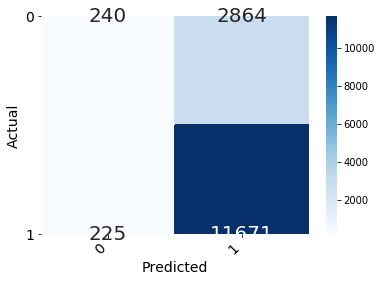

In [64]:
MainPipe = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', RandomForestClassifier(n_estimators=90) )])
# split sample into train and test

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, stratify=y,random_state=42)  # random_state=21 # stratify=y

# Fit Model
MainPipe.fit(X_train,y_train)

# Predict model
y_pred = MainPipe.predict(X_test)

#Output accuracy of our prediction
print(accuracy_score(y_test, y_pred))

# Visualize the confusion matrix to make it easier to read
con_matrix = confusion_matrix(y_test, y_pred)
confusion_matrix_df = pd.DataFrame(con_matrix, ('0', '1'), ('0', '1'))
heatmap = sns.heatmap(confusion_matrix_df, annot=True, annot_kws={"size": 20}, fmt="d", cmap="Blues")
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize = 14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize = 14)
plt.ylabel('Actual', fontsize = 14)
plt.xlabel('Predicted', fontsize = 14)

# Print the classification report
print(classification_report(y_test, y_pred))

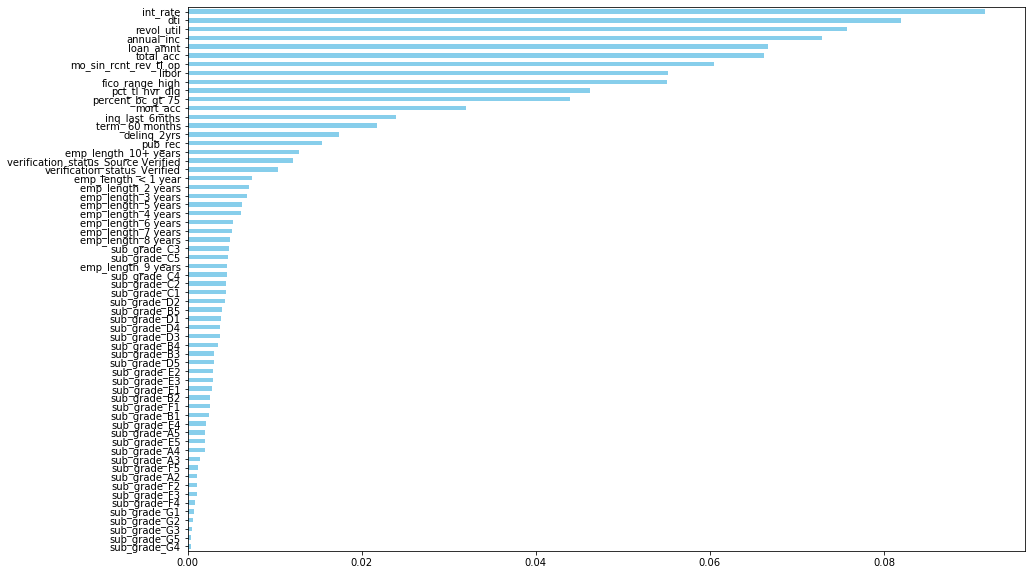

In [65]:
# Create a pd.Series of features importances
importances_rf = pd.Series(MainPipe.named_steps['classifier'].feature_importances_, index = pd.get_dummies(X,drop_first=True).columns)

# Sort importances_rf
sorted_importances_rf = importances_rf.sort_values()

# Make a horizontal bar plot
plt.figure(figsize=(15,10))
sorted_importances_rf.plot(kind='barh', color='skyblue'); 
plt.show()

We would ultimately like to perform a classification technique that produces probabilities. This will allow us to pick the loans with the lowest expected probability of default. Therefore, we tried logistic regression as shown below.

In [90]:
# Import required modules
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
#from sklearn.impute import Imputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer


#1 Inner Pipeline1: Create a numeric transformer with 2 steps
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy = 'median')),
    ('scaler', StandardScaler())])

#2 Inner Pipeline2: Create a categorical transformer with 2 steps
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

#3 Create Preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

0.7936666666666666
              precision    recall  f1-score   support

 Charged Off       0.51      0.06      0.11      3104
  Fully Paid       0.80      0.98      0.88     11896

    accuracy                           0.79     15000
   macro avg       0.66      0.52      0.50     15000
weighted avg       0.74      0.79      0.72     15000



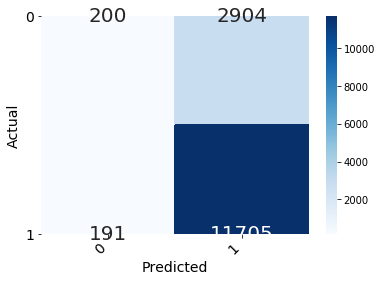

In [67]:

from sklearn.linear_model import LogisticRegression
MainPipe = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', LogisticRegression(solver='lbfgs',max_iter=10000) )])

# split sample into train and test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, stratify=y)  # random_state=21 # stratify=y

# Fit Model
MainPipe.fit(X_train, y_train)

# Predict model
y_pred = MainPipe.predict(X_test)

# Output the accuracy of our prediction
from sklearn.metrics import accuracy_score
print(accuracy_score(y_test, y_pred))

# Visualize the confusion matrix to make it easier to read
from sklearn.metrics import confusion_matrix
con_matrix = confusion_matrix(y_test, y_pred)
confusion_matrix_df = pd.DataFrame(con_matrix, ('0', '1'), ('0', '1'))
heatmap = sns.heatmap(confusion_matrix_df, annot=True, annot_kws={"size": 20}, fmt="d", cmap="Blues")
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize = 14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize = 14)
plt.ylabel('Actual', fontsize = 14)
plt.xlabel('Predicted', fontsize = 14)

# Print the classification report
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

Although this accuracy sounds good, it is not great considering the baseline accuracy of predicting all loans to be fully paid. Therefore, we will try rebalancing the data so it has approximately 50 percent defaulted and 50 percent fully paid loans. This will allow us to train on data to better learn the distinguishing factors of defaulted vs fully paid

In [144]:
data=df123[final_vars]
FP = data.copy().loc[data['loan_status'] == 'Fully Paid'].sample(n=25000, random_state=1)
CO = data.copy().loc[data['loan_status'] == 'Charged Off'].sample(n=25000, random_state=1)
data = pd.concat([FP, CO], ignore_index=True).sample(frac=1)

numeric_features = data.select_dtypes(include=['int64', 'float64']).columns
categorical_features = data.select_dtypes(include=['object', 'category']).columns
categorical_features=categorical_features.drop(['loan_status'])
X = data.loc[:, data.columns != 'loan_status']
# Create a new dataframe y that includes only our 
y = data.loan_status

0.6500666666666667
              precision    recall  f1-score   support

 Charged Off       0.64      0.69      0.66      7500
  Fully Paid       0.66      0.61      0.64      7500

    accuracy                           0.65     15000
   macro avg       0.65      0.65      0.65     15000
weighted avg       0.65      0.65      0.65     15000



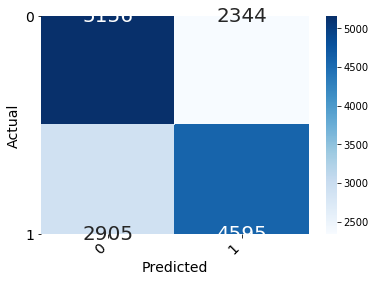

In [145]:
from sklearn.linear_model import LogisticRegression
MainPipe = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', LogisticRegression(solver='lbfgs',max_iter=10000) )])

# split sample into train and test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, stratify=y)  # random_state=21 # stratify=y

# Fit Model
MainPipe.fit(X_train, y_train)

# Predict model
y_pred = MainPipe.predict(X_test)

# Output the accuracy of our prediction
from sklearn.metrics import accuracy_score
print(accuracy_score(y_test, y_pred))

# Visualize the confusion matrix to make it easier to read
from sklearn.metrics import confusion_matrix
con_matrix = confusion_matrix(y_test, y_pred)
confusion_matrix_df = pd.DataFrame(con_matrix, ('0', '1'), ('0', '1'))
heatmap = sns.heatmap(confusion_matrix_df, annot=True, annot_kws={"size": 20}, fmt="d", cmap="Blues")
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize = 14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize = 14)
plt.ylabel('Actual', fontsize = 14)
plt.xlabel('Predicted', fontsize = 14)

# Print the classification report
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

In [147]:
#anti join functions taken from https://gist.github.com/sainathadapa/eb3303975196d15c73bac5b92d8a210f

def anti_join(x, y, on):
    """Return rows in x which are not present in y"""
    ans = pd.merge(left=x, right=y, how='left', indicator=True, on=on)
    ans = ans.loc[ans._merge == 'left_only', :].drop(columns='_merge')
    return ans

def anti_join_all_cols(x, y):
    """Return rows in x which are not present in y"""
    assert set(x.columns.values) == set(y.columns.values)
    return anti_join(x, y, x.columns.tolist())
larger_test_set = anti_join_all_cols(df123[final_vars],data)

In [151]:
print(classification_report(larger_test_set['loan_status'],MainPipe.predict(larger_test_set.loc[:, data.columns != 'loan_status'])))

              precision    recall  f1-score   support

 Charged Off       0.30      0.69      0.42    208261
  Fully Paid       0.89      0.61      0.73    859132

    accuracy                           0.63   1067393
   macro avg       0.59      0.65      0.57   1067393
weighted avg       0.77      0.63      0.67   1067393



The Logistic Regression did pretty well (about 65 percent accuracy vs. a 50 percent baseline) but the problem is it does not work well when you then test it on imbalanced data again (worse than baseline). Our data will normally be imbalanced since most loans do not default. For this reason we will stick with the stratified sampling method to train our model

# Return Model

Now that we have a model to predict *loan_status* based on our team's curated list of variables, our team wanted to take this process a step further to predict the expected returns on these loans. Our final goal is to build a model that combines finding high return and lowest probability of default to give the best list of investable loans to Dr. D. 

The below output showcases our formula for calculating return of a loan. Essentially, we created an annualized return variable which was: (the total amount paid on the loan minus the total amount invested in the loan)/(total amount invested in the loan). We then annualized this value by multiplying by 12/term. We will use this newly created return variable as our response variable. 

In [84]:
data_rm = df_final.copy()
data_rm['total_pymnt']=df.total_pymnt
data_rm['funded_amnt']=df.funded_amnt
data_rm['term']=np.where(data_rm['term']==' 36 months',36,60)
data_rm['return']=(((data_rm.total_pymnt)-data_rm.funded_amnt)/data_rm.funded_amnt)*12/data_rm.term
data_rm = data_rm.drop(['total_pymnt','funded_amnt','term'],axis=1)
data_rm = data_rm.dropna()

In [85]:
data=data_rm.sample(n=50000, random_state=1)
numeric_features = data.select_dtypes(include=['int64', 'float64']).columns
categorical_features = data.select_dtypes(include=['object', 'category']).columns
categorical_features=categorical_features.drop(['loan_status'])
X = data.loc[:, data.columns != 'loan_status']
numeric_features = numeric_features.drop('return')
X= data.drop(['return'],axis=1)
# Create a new dataframe y that includes only our 
y = data['return']

In [86]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
#from sklearn.impute import Imputer
from sklearn.compose import ColumnTransformer


#1 Inner Pipeline1: Create a numeric transformer with 2 steps
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy = 'median'))])

#2 Inner Pipeline2: Create a categorical transformer with 2 steps
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

#3 Create Preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

In [87]:
from sklearn.ensemble import RandomForestRegressor, ExtraTreesClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.feature_selection import SelectFromModel, SelectKBest
from matplotlib import pyplot as plt
MainPipe = Pipeline(steps=[('preprocessor', preprocessor),
                      ('regressor', RandomForestRegressor(n_estimators=90) )])
#('fs',SelectFromModel(ExtraTreesClassifier())),
# split sample into train and test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=42)  # random_state=21 # stratify=y


# Fit Model
MainPipe.fit(X_train,y_train)

# Predict model
y_pred = MainPipe.predict(X_test)

In [88]:
from sklearn import metrics, model_selection
def evaluate(y_test, y_pred):
    # this block of code returns all the metrics we are interested in 
    mse = metrics.mean_squared_error(y_test, y_pred)
    msa = metrics.mean_absolute_error(y_test, y_pred)
    r2 = metrics.r2_score(y_test, y_pred)

    print("Mean squared error: ", mse)
    print("Mean absolute error: ", msa)
    print("R^2 : ", r2)
    
    # this creates a chart plotting predicted and actual 
    plt.figure(figsize=(12,6))
    plt.scatter(y_test, y_pred)
    plt.xlabel("Actual Interest over Libor: $y_i$")
    plt.ylabel("Predicted Interest over Libor: $\hat{y}_i$")
    plt.title("Interest over Libor vs Predicted Interest over Libor: $y_i$ vs $\hat{y}_i$")

Mean squared error:  0.008320484773912942
Mean absolute error:  0.06615003937669876
R^2 :  -0.02353332848773526


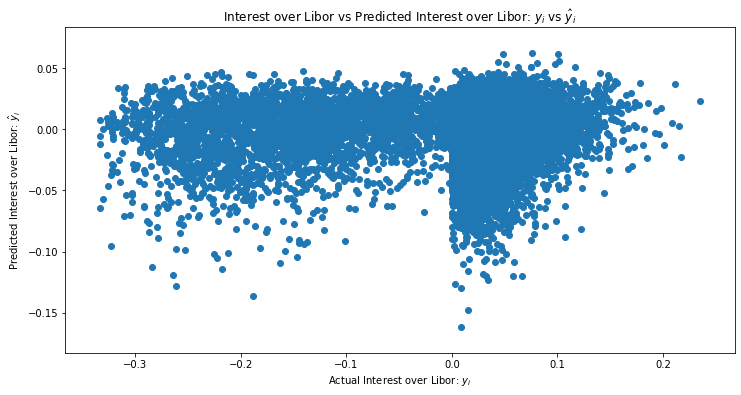

In [89]:
evaluate(y_test, y_pred)

Unfortunately the return model did not work as we would have liked. It appears that we either calculated it wrong or that the variables are inaccurate. 

Regardless, we would like to show how we would evaluate our default model- using the 1000 loans with the lowest probability of default. We will show the average return of this portfolio. Although our return was not calculated correctly, this is how we would evaluate the model in a perfect world.

In [128]:
data=data_rm.sample(n=50000, random_state=1)
numeric_features = data.select_dtypes(include=['int64', 'float64']).columns
categorical_features = data.select_dtypes(include=['object', 'category']).columns
categorical_features=categorical_features.drop(['loan_status'])
X = data.loc[:, data.columns != 'loan_status']
numeric_features = numeric_features.drop('return')
#X= data.drop(['return'],axis=1)
# Create a new dataframe y that includes only our 
y = data['loan_status']

In [129]:
# Import required modules
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
#from sklearn.impute import Imputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer


#1 Inner Pipeline1: Create a numeric transformer with 2 steps
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy = 'median')),
    ('scaler', StandardScaler())])

#2 Inner Pipeline2: Create a categorical transformer with 2 steps
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

#3 Create Preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

0.796
              precision    recall  f1-score   support

 Charged Off       0.56      0.06      0.10      3094
  Fully Paid       0.80      0.99      0.88     11906

    accuracy                           0.80     15000
   macro avg       0.68      0.52      0.49     15000
weighted avg       0.75      0.80      0.72     15000



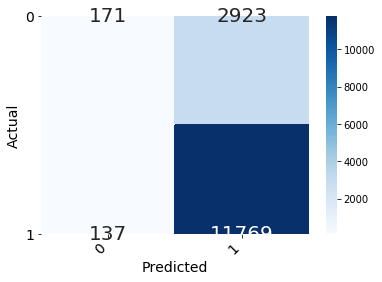

In [130]:

from sklearn.linear_model import LogisticRegression
MainPipe = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', LogisticRegression(solver='lbfgs',max_iter=10000) )])

# split sample into train and test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, stratify=y)  # random_state=21 # stratify=y

test_returns = X_test['return']
X_test= X_test.drop(['return'],axis=1)
X_train = X_train.drop(['return'],axis=1)

# Fit Model
MainPipe.fit(X_train, y_train)

# Predict model
y_pred = MainPipe.predict(X_test)

# Output the accuracy of our prediction
from sklearn.metrics import accuracy_score
print(accuracy_score(y_test, y_pred))

# Visualize the confusion matrix to make it easier to read
from sklearn.metrics import confusion_matrix
con_matrix = confusion_matrix(y_test, y_pred)
confusion_matrix_df = pd.DataFrame(con_matrix, ('0', '1'), ('0', '1'))
heatmap = sns.heatmap(confusion_matrix_df, annot=True, annot_kws={"size": 20}, fmt="d", cmap="Blues")
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize = 14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize = 14)
plt.ylabel('Actual', fontsize = 14)
plt.xlabel('Predicted', fontsize = 14)

# Print the classification report
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

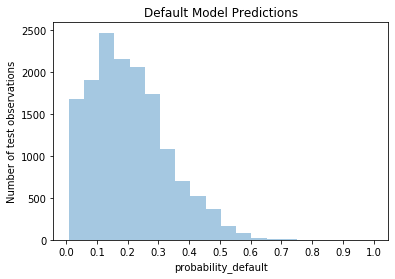

In [131]:
X_test=X_test.copy()
X_test.loc[:,'probability_default']=[x[0] for x in MainPipe.predict_proba(X_test)]
#plt.hist(X_test.probability_default, bins=np.linspace(0,1,21))
sns.distplot(X_test.probability_default,bins=20,kde=False, rug=False)
plt.xticks(np.linspace(0,1,11))
plt.ylabel('Number of test observations')
plt.title('Default Model Predictions')
plt.show()

In [136]:
np.mean(test_returns[X_test.sort_values('probability_default')[:1000].index])

-0.0024187085097869144

Above is the average annualized return (remember that we did not correctly calculate return) from picking loans based on lowest expected probability of default. Lastly, we will show the average annualized return from randomly picking 1000 loans from the test set.

In [138]:
np.mean(test_returns.sample(n=1000))

0.0014857269785491984